In [17]:
# !pip install torch torchvision matplotlib numpy tqdm


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=512, shuffle=False)


In [20]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = MLP().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)


In [21]:
def hessian_vector_product(loss, model, v):
    grads = torch.autograd.grad(loss, model.parameters(),
                                create_graph=True, retain_graph=True)

    grad_vector = torch.cat([g.contiguous().view(-1) for g in grads])
    v_vector = torch.cat([vi.contiguous().view(-1) for vi in v])
    grad_dot_v = torch.dot(grad_vector, v_vector)

    hv = torch.autograd.grad(grad_dot_v, model.parameters(), retain_graph=True)
    return hv

def compute_sharpness(model, criterion, data, target, max_iter=30):
    model.eval()
    output = model(data)
    loss = criterion(output, target)

    v = [torch.randn_like(p) for p in model.parameters()]
    v = [vi / torch.norm(vi) for vi in v]

    for _ in range(max_iter):
        v_new = hessian_vector_product(loss, model, v)
        v_flat = torch.cat([vi.view(-1) for vi in v_new])
        norm = torch.norm(v_flat)
        v = [vi / norm for vi in v_new]

    return norm.item()

sharpness_values = []
train_losses = []

for epoch in range(5):
    total_loss = 0
    for data, target in tqdm(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Sample batch to compute sharpness
    sample_data, sample_target = next(iter(train_loader))
    sample_data, sample_target = sample_data.cuda(), sample_target.cuda()

    s = compute_sharpness(model, criterion, sample_data, sample_target)

    sharpness_values.append(s)
    train_losses.append(total_loss / len(train_loader))

    print(f"Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Sharpness = {s:.4f}")


100%|██████████| 235/235 [00:12<00:00, 18.72it/s]


Epoch 1: Loss = 0.3642, Sharpness = 12.4792


100%|██████████| 235/235 [00:12<00:00, 19.42it/s]


Epoch 2: Loss = 0.1506, Sharpness = 6.2910


100%|██████████| 235/235 [00:11<00:00, 19.63it/s]


Epoch 3: Loss = 0.1184, Sharpness = 5.9985


100%|██████████| 235/235 [00:11<00:00, 19.61it/s]


Epoch 4: Loss = 0.0940, Sharpness = 4.1698


100%|██████████| 235/235 [00:12<00:00, 19.23it/s]


Epoch 5: Loss = 0.0809, Sharpness = 3.7687


In [22]:
def test_accuracy(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    return 100 * correct / total

print("Test Accuracy:", test_accuracy(model), "%")


Test Accuracy: 97.08 %


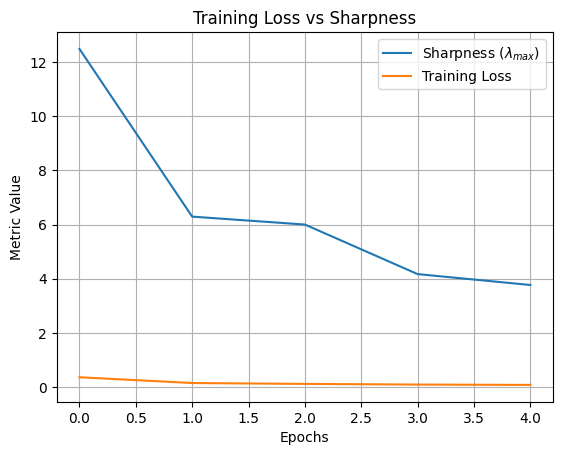

In [23]:
plt.plot(sharpness_values, label="Sharpness ($λ_{max}$)")
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.title("Training Loss vs Sharpness")
plt.legend()
plt.grid(True)
plt.show()


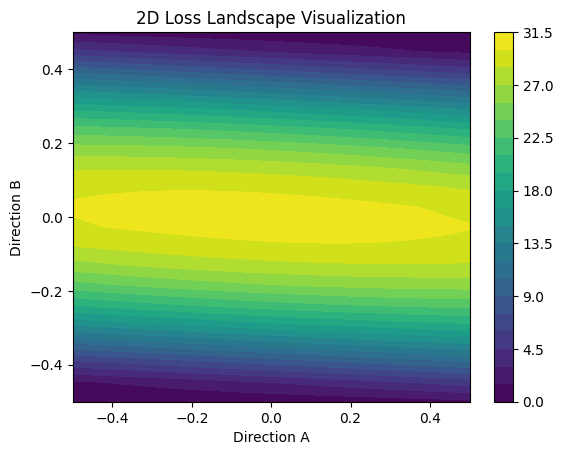

In [24]:
def visualize_landscape(model, data, target, steps=20, r=0.5):
    model.eval()
    loss = criterion(model(data), target)

    v = [torch.randn_like(p) for p in model.parameters()]
    w = [torch.randn_like(p) for p in model.parameters()]
    v = [vi / torch.norm(vi) for vi in v]
    w = [wi / torch.norm(wi) for wi in w]

    alphas = np.linspace(-r, r, steps)
    betas = np.linspace(-r, r, steps)
    Z = np.zeros((steps, steps))

    for i, a in enumerate(alphas):
        for j, b in enumerate(betas):
            idx = 0
            with torch.no_grad():
                for p, vi, wi in zip(model.parameters(), v, w):
                    p.copy_(p + a*vi + b*wi)
                Z[i, j] = criterion(model(data), target).item()
            idx += 1

    plt.contourf(alphas, betas, Z, 20, cmap='viridis')
    plt.colorbar()
    plt.title("2D Loss Landscape Visualization")
    plt.xlabel("Direction A")
    plt.ylabel("Direction B")
    plt.show()

sample_data, sample_target = next(iter(train_loader))
visualize_landscape(model, sample_data.cuda(), sample_target.cuda())
